In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from recommender import User, Movie, Recommender
import matplotlib.pylab as plt
import math
import numpy as np
from plot import plot_statistics, plot_user_movie_ratings, plot_ratings_distribution, plot_ratings_distribution_kde
import optuna

## Dataset Summary

In [2]:
rec = Recommender(k=20)
rec.initialize_from_csv("ml-25m/movies.csv", "ml-25m/ratings.csv")


Initialized
Parsed ml-25m/ratings.csv
Parsed ml-25m/movies.csv


Reformatting movie ratings: 100%|██████████| 59047/59047 [00:20<00:00, 2943.58it/s] 


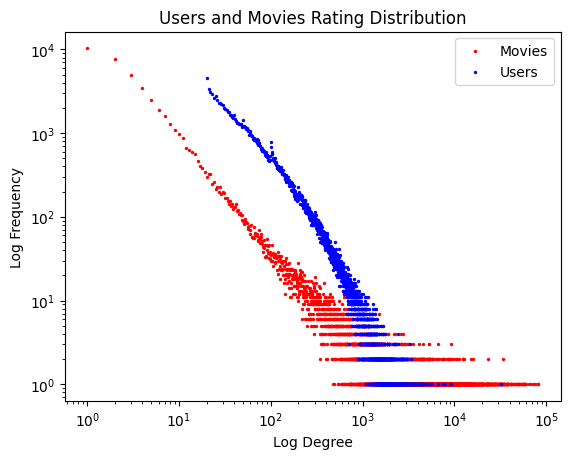

In [4]:
plot_user_movie_ratings(rec)

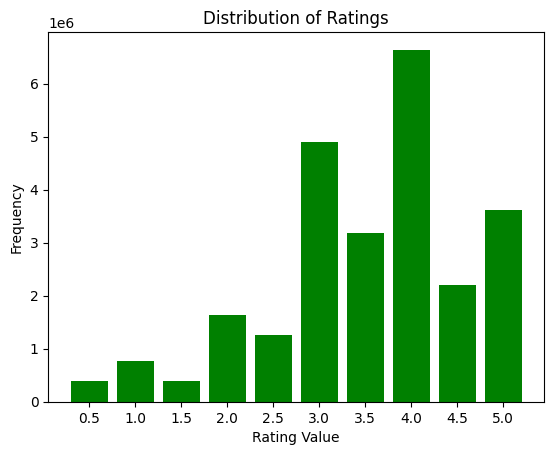

In [5]:
plot_ratings_distribution(rec)

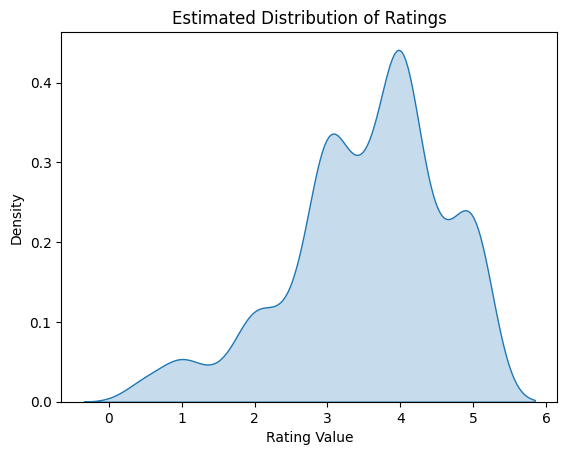

In [6]:
plot_ratings_distribution_kde(rec)

## Hyperparameter Tuning
### Initial test run to determine appropriate number of iterations

Initialized
Parsed ml-25m/ratings.csv
Parsed ml-25m/movies.csv


Reformatting movie ratings: 100%|██████████| 59047/59047 [00:26<00:00, 2198.98it/s] 


162541
59047


100%|██████████| 25/25 [15:37<00:00, 37.52s/it]


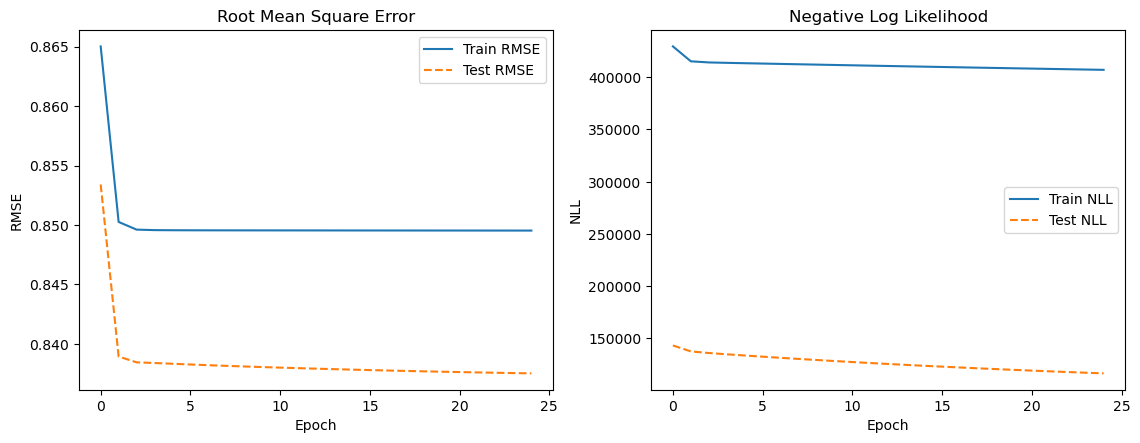

In [2]:
rec = Recommender(k = 20)
rec.initialize_from_csv("ml-25m/movies.csv", "ml-25m/ratings.csv", train_test_split=True)
print(len(rec.users))
print(len(rec.movies))

statistics_biases = rec.fit_biases_only(max_iter=25)
plot_statistics(statistics_biases, biases_only=True, train_test_split=True, save_suffix="init_biases_only")

In [3]:
statistics_embed = rec.fit(max_iter=25)
plot_statistics(statistics_embed, biases_only=False, train_test_split=True, save_suffix="init_embed")

Initialized variables and statistics: 0.2212510108947754s


### Determining the Best Value of k 

In [ ]:
# Initialize the recommender system
k_values = [2, 5, 10, 20]
max_iter_embed = 20
max_iter_biases = 20

all_stats_biases = []
all_stats_embed = []
for k in k_values:
    rec.set_k(k)
    statistics_biases = rec.fit_biases_only(max_iter=max_iter_biases)
    statistics_embed = rec.fit(max_iter=max_iter_embed)
    all_stats_biases.append(statistics_biases)
    all_stats_embed.append(statistics_embed)

for i in range(k_values):
    print(f"RMSE_train_{k_values[i]}(biases): {all_stats_biases[i]["RMSEs"][-1]}")
    print(f"RMSE_train_{k_values[i]}(embed): {all_stats_embed[i]["RMSEs"][-1]}")
    print(f"RMSE_test_{k_values[i]}(biases): {all_stats_biases[i]["RMSEs_test"][-1]}")
    print(f"RMSE_test_{k_values[i]}(embed): {all_stats_embed[i]["RMSEs_test"][-1]}")

### Finding Good Values for $\lambda$, $\gamma$ and $\tau$

In [2]:
#setting k to best value of k
rec.set_k(20)

def objective(trial):
    # Suggest values for the gamma, lam, tau hyperparameters
    gamma = trial.suggest_float("gamma", 0.01, 0.1)
    lam = trial.suggest_float("lam", 0.01, 0.1)
    tau = trial.suggest_float("tau", 0.01, 0.1)

    # Set model parameters
    rec.set_params(gamma=gamma, lam=lam, tau=tau)

    # Fit model and get statistics
    statistics = rec.fit(max_iter=10)
    final_RMSE = statistics["RMSEs_test"][-1]

    #Optimize for best test RMSE
    return final_RMSE

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)
print("Best value:", study.best_value)

Initialized
Parsed ml-25m/ratings.csv
Parsed ml-25m/movies.csv


Reformatting movie ratings: 100%|██████████| 59047/59047 [00:24<00:00, 2391.06it/s] 
[I 2024-05-16 11:58:07,384] A new study created in memory with name: no-name-631650bd-c2d3-42ba-b75f-9a8c91d633ad


Initialized variables and statistics: 0.19160127639770508s
Ran initial update to user and item biases: 60.508830308914185s


100%|██████████| 10/10 [16:01<00:00, 96.14s/it]
[I 2024-05-16 12:15:09,535] Trial 0 finished with value: 0.5224850450748008 and parameters: {'gamma': 0.012907227488799399, 'lam': 0.02575607725959514, 'tau': 0.024011754982783316}. Best is trial 0 with value: 0.5224850450748008.


Initialized variables and statistics: 0.19095468521118164s


[W 2024-05-16 12:15:33,303] Trial 1 failed with parameters: {'gamma': 0.012857079305805364, 'lam': 0.03993461968303267, 'tau': 0.08806047065231654} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/james/.local/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_14430/226292408.py", line 15, in objective
    statistics = rec.fit(max_iter=10)
                 ^^^^^^^^^^^^^^^^^^^^
  File "/home/james/Modules/Masters/AMLS/Practical/recommender.py", line 452, in fit
    self.update_statistics(statistics, extra_stats=extra_stats)
  File "/home/james/Modules/Masters/AMLS/Practical/recommender.py", line 311, in update_statistics
    neg_log_lik, RMSE = self.metrics(test=test)
                        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/james/Modules/Masters/AMLS/Practical/recommender.py", line 207, in metrics
    predictio

KeyboardInterrupt: 

## Dummy Users

In [7]:
ratings = [("Lord of the Rings: The Fellowship of the Ring, The (2001)", 5.0)]
uid = rec.insert_dummy_user(ratings)
print(uid)

162542


In [8]:
ratings = [("Minions (2015)", 5.0)]
uid_2 = rec.insert_dummy_user(ratings)
print(uid_2)

162543


In [11]:
ratings = [("Fight Club (1999)", 5.0)]
uid_3 = rec.insert_dummy_user(ratings)
print(uid_3)

162545


Initialized variables and statistics: 0.1754910945892334s
Ran initial update to user and item biases: 58.587913036346436s


100%|██████████| 5/5 [07:33<00:00, 90.60s/it]


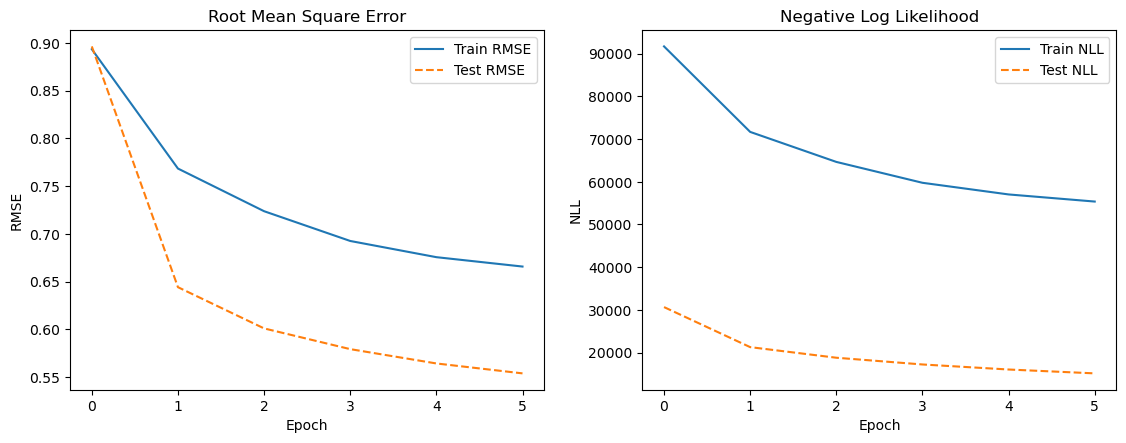

In [18]:
extra_stats = False
statistics = rec.fit(max_iter=5, extra_stats=extra_stats)
plot_statistics(statistics, train_test_split=True, extra_stats=extra_stats)

In [19]:
pred_ratings, titles = rec.predict_movies_for_user(uid)
print(titles[0:10])
print(pred_ratings[0:10])
pred_ratings, titles = rec.predict_movies_for_user(uid_2)
print(titles[0:10])
print(pred_ratings[0:10])
pred_ratings, titles = rec.predict_movies_for_user(uid_3)
print(titles[0:10])
print(pred_ratings[0:10])

['Lord of the Rings: The Return of the King, The (2003)'
 'Lord of the Rings: The Fellowship of the Ring, The (2001)'
 'Lord of the Rings: The Two Towers, The (2002)'
 'Fullmetal Alchemist: The Sacred Star of Milos (2011)'
 'Hobbit: An Unexpected Journey, The (2012)'
 'Patton Oswalt: Tragedy Plus Comedy Equals Time (2014)'
 'Hobbit: The Desolation of Smaug, The (2013)' 'Five Came Back (2017)'
 'That Munchhausen (1979)' 'Cruise, The (1998)']
[4.82019983 4.7730652  4.72766701 2.98500506 2.81040558 2.68362113
 2.5565515  2.53557357 2.52718796 2.47982656]
['Rocky Horror Picture Show, The (1975)'
 '47 Samurai (Chûshingura) (Loyal 47 Ronin, The) (1962)' 'Minions (2015)'
 "No. 1 Ladies' Detective Agency, The (2008)" 'Tango (1998)'
 'Billy Elliot: The Musical (2014)' 'Merry Madagascar (2009)'
 'Gabriel Iglesias: Hot and Fluffy (2007)' 'Big Eden (2000)'
 'Destiny Turns on the Radio (1995)']
[4.60276323 4.56131898 4.43418921 4.34995415 4.26198876 4.08143704
 3.94050162 3.93534639 3.89927385 3.78